# Analysis-ready, cloud-optimized data: writing zarr directories

This tutorial will introduce analysis-ready, cloud-optimized (ARCO) data and describe one real-world example of restructuring some glaciological data and writing to an ARCO format, zarr. The data we will take a look at is from an ice-penetrating radar called the autonomous phase-sensitive radio-echo sounder (ApRES). 

A zarr store (or directory) is an ARCO data format that is ideally suited for storing high-dimensional, large volume data in the cloud. A key characteristic of zarr stores is that they are 'chunked', meaning that the data is broken up into smaller pieces. This allows for parallel access to the data, which is very useful when you are trying to access subsets of large datasets and/or process large volumes of data in parallel. 

Depending on the configuration of the ApRES radar, and the survey conducted, it can produce high-dimensional, very large datasets, making these data suitable for storage with zarrs. 

Before we get to the ApRES data we should make sure we understand what we mean by high-dimensional data and chunked data. 



## High-dimensional data: xarray
For our purposes, high-dimensional data is data that has more than 2 dimensions. For example, a typical satallite image is a two-dimensional dataset with two spatial dimensions, x and y (or latitude and longitude). If the satallite image has multiple bands it would be a three-dimensional dataset with two spatial dimensions and one band dimension, and if the satallite image has multiple time steps it would be a four-dimensional dataset with two spatial dimensions, one band dimension, and one time dimension. 

[Xarray](http://xarray.pydata.org/en/stable/) is a python package designed to allow you store and process high-dimensional data. It is built on top of [numpy](https://numpy.org/), which is deals with arrays of data. Xarray adds very useful features to numpy, including labelling of dimensions and broadcasting of operations across dimensions. Xarray also works very nicely with [dask](https://dask.org/), which is yet another python package, which allows you to 'chunk' your data and process it in parallel.

Before we get onto dask, let's take a look at xarray.

In [2]:
import xarray as xr

Let's load an example xarray dataset, supplied with the xarray package:

In [3]:
ds = xr.tutorial.load_dataset("air_temperature")
ds

<xarray.Dataset>
Dimensions:  (lat: 25, time: 2920, lon: 53)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 241.2 242.5 243.5 ... 296.5 296.2 295.7
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

This provides a convenient view the structure of the data. We see that there are three dimensions (`lat`, `lon` and `time`) and one variable (`air`). The variable `air` and the coorinates `lat`, `lon` and `time` are all stored as numpy arrays. You can access the numpy array underlying the variable in dataset `air` and verify its type as follows:

In [4]:
ds.air.values[0:2, 0:2, 0:2]

array([[[241.2    , 242.5    ],
        [243.79999, 244.5    ]],

       [[242.09999, 242.7    ],
        [243.59999, 244.09999]]], dtype=float32)

In [5]:
print(f"The variable air has type {type(ds.air.values)}")

The variable air has type <class 'numpy.ndarray'>


A great thing about xarray is that it allows to very quickly take a look at, process, and plot this kind of data. For example, we can plot the mean of `air` over the `time` dimension as follows:

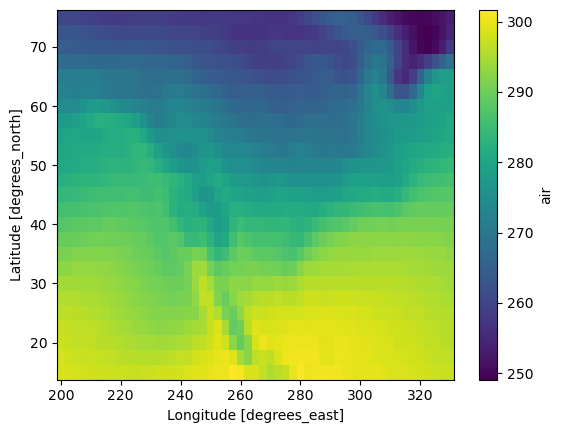

In [7]:
ds.air.mean(dim="time").plot();


## Chunking: dask
The xarray above (`ds`) contained numpy arrays. To process or plot any part of a variable, we need to load all of it into memory. This is fine if the data are small; the dataset above was only

In [8]:
print(f"{ds.nbytes/1e6} MB")

15.499672 MB


but this would be an issue if a variable was, say, 100GB. This would be too large to fit into memory on most computers and would prevent you from processing or plotting the data. This is where chunking and dask come in. Dask provides a new data structure, called a dask array, which is like a numpy array except that it is split up into smaller pieces called chunks. Let's load an example dask array (straight from the dask [documentation](https://examples.dask.org/array.html#Create-Random-array)): 

In [9]:
import dask.array as da
x = da.random.random((1e6, 1e6), chunks=(5000, 5000))
x

dask.array<random_sample, shape=(1000000, 1000000), dtype=float64, chunksize=(5000, 5000), chunktype=numpy.ndarray>

This created a dask array containing random values between -0.5 and 0.5. Calling `x` displays a handy table containing information about this dask array. It's total size is 7TB! Clearly this is much too large to fit into memory. In fact, nothing has been loaded into memory except the structure of the dask array (i.e. the number and shape of the chunks) and the information needed to create it when we need it (i.e. the method `random`). 

The table also includes information on the chunks. There are 40,000 of them and each one is 190MB and 5000 by 5000 elements in size. Note that we chose this chunk size when we created the dask array. This is the key to dask arrays: we can choose the chunk size to suit our needs. Choosing the wrong chunk size can cause all sorts of issues, as we will see later in our real world example.

Two great advantages of using dask array instead of an ordinary numpy array are 1) that we can view and plot a subset of the data without loading the whole thing into memory, and 2) we can very easily process the data in parallel. Let's first load a subset of the data into memory and plot it:



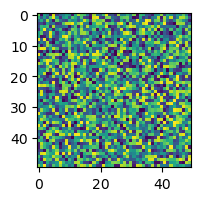

In [10]:
import matplotlib.pyplot as plt
x_sub = x[0:50, 0:50]
plt.figure(figsize=(2, 2))
plt.imshow(x_sub);

In [11]:
x_sub.nbytes/1e6

0.02

Next, let's start up a cluster and load and process a much larger subset of the data in parallel:

# ToDo when in cryocloud

## Xarray + dask
Xarray and dask work very nicely together. The dataset we looked at above (`ds`) was made up of numpy arrays. We can instead tell xarray to load the data as dask arrays, therefore avoiding loading anything into memory until it we need it. This is called lazily loading the data. We do this by defining the `chunks` argument when we load the data:

In [12]:
ds_dask = xr.tutorial.open_dataset('air_temperature',
                              chunks={'lat': 5, 'lon': 5, 'time': -1})
ds_dask

<xarray.Dataset>
Dimensions:  (lat: 25, time: 2920, lon: 53)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 dask.array<chunksize=(2920, 5, 5), meta=np.ndarray>
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

Now if we take a look at the variable `air` in `ds_dask` we can see that it is a dask array:

In [14]:
ds_dask.air

<xarray.DataArray 'air' (time: 2920, lat: 25, lon: 53)>
dask.array<open_dataset-air, shape=(2920, 25, 53), dtype=float32, chunksize=(2920, 5, 5), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

## xApRES
### ApRES data --> xarray --> zarr --> dask 

We are now ready to take a look at some real-world data. The data we will look at is from an ApRES radar. We will 
- discuss the structure of an ApRES survey,
- load some raw ApRES data,
- structure the data as an xarray, and 
- write this xarray to a zarr directory. 

This will make use of a library we have developed called [xApRES](https://github.com/ldeo-glaciology/XApRES). The main developers of this library have so far been Jonny Kingslake, George Lu, and Elizabeth Case. We very much welcome collaboration from anyone interested in efficietn ways to process, store, and analyze ApRES data.

## Structure of an ApRES survey
The structure of an ApRES survey can get quite complex. The figure below depicts the structure.

![ApRES data structure](../img/cropped_ApRES_data_diagram.png)



### Chirps
The radar emits individual 'chirps' which generate a 40,001-element-long time series of data. The chirps are emitted at a rate of 1 per second. 
### Bursts
The chirps are grouped into 'bursts', which each contain a user-definable number of chirps. The system is setup perform bursts at regular intervals. The data we are going to look at below has a burst interval of 15 minutes.
### Attenuator settings
The ApRES has user-definable attenuator settings which are chosen during installation to ensure the signal is not too strong or too weak. Typically we choose more than one attenuator setting and cycle through them during each burst. So for example, if we have 3 attneuator settings, and 20 chirps per burst, per settting, the sequence of chirps would be 20 chirps using attenuator setting 1, followed by 20 chirps using attenuator setting 2, followed by 20 chirps using attenuator setting 3, followed by 20 chirps using attenuator setting 1, and so on.

This complexity leads to a four-dimensional dataset: 1) the time of each burst, 2) the chirp number within each burst, 3) the attenuator setting, and 4) the sample number in chirp. A typical workflow for processing datasets collected by such a survey is through nested for-loops and it is a major challenge keeping track of which chirp belongs where. 

This is where xarray can really help. Let's next load some raw ApRES data using some scripts fro a library we have been developing called xApRES.



## Load raw ApRES data
Raw ApRES data are stored in files with an extension `.dat`. First we install and import the xApRES library:

In [41]:
!pip install xapres
import xapres as xa

### The data
The ApRES data we will be using were collected in the ablation zone of the Greenland Ice Sheet by a team led by Meredith Nettles (Lamont-Doherty Earth Observatory, LDEO) and Laura Stevens (University of Oxford), including George Lu (LDEO), Stacy Larochelle (LDEO), Marianne Okal (Earthscope), Kristin Arnold (IRIS Alpine), and Josh Rines (Stanford University). The project was funded by the US National Science Foundation (project number: 2003464). Three ApRES units were positioned near several supraglacial lakes that periodically drain to the bed of the ice sheet. The units collected a burst every 15 minutes for up to 18 months. You can learn more about the science being done with these data (using the tools described here) in two oral presentation at AGU this week: [one](https://agu.confex.com/agu/fm23/meetingapp.cgi/Paper/1321546) led by Stacy Larochelle and [one](https://agu.confex.com/agu/fm23/meetingapp.cgi/Paper/1316057) led by George Lu.

The map below shows the location of the three ApRES units. We will be looking at data from A11.

![Map of ApRES locations in greenland](../img/ApRES_map.png)

Usinf xApRES we will create an instance of a `from_dats` object, then use two methods of these objects (`list_files` and `load_single`) to load 1 chirp from within 1 burst from within 1 `.dat` file.  

In [51]:
fd = xa.load.from_dats()
dat_file_list = fd.list_files(directory=f'gs://ldeo-glaciology/GL_apres_2022/A101', 
                remote_load = True)
fd.load_single(dat_file_list[30], remote_load = True, burst_number=0, chirp_num=0)


Let's take a look at the raw chirp data. It is 40001 elements long, as mentioned above, and we can plot it as follows:

In [52]:
len(fd.single_chirp.vdat)

40001

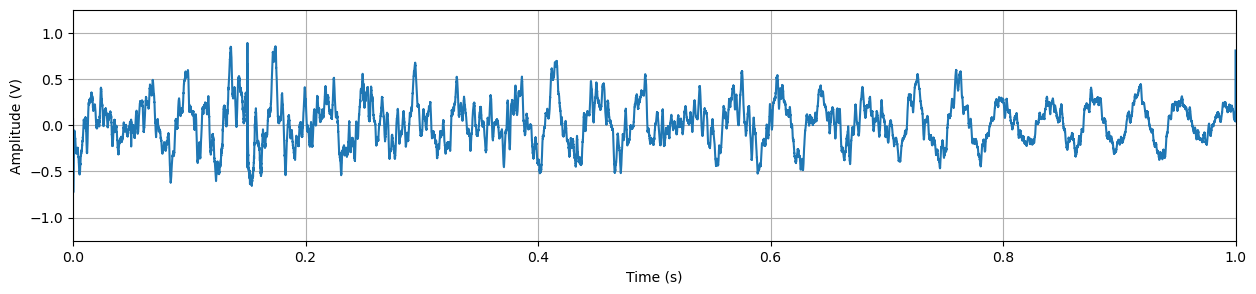

In [90]:
plt_1 = plt.figure(figsize=(15, 3))
plt.plot(fd.single_chirp.t, fd.single_chirp.vdat)
plt.axis([0,fd.single_chirp.t[-1],-1.25,1.25])
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (V)")
plt.grid("on")

We wont get into the details of processing ApRES data., but to obtain a representation of the reflection power as a function of depth we apply a fast fourier transform to the chirp. This is done in xApRES as follows:

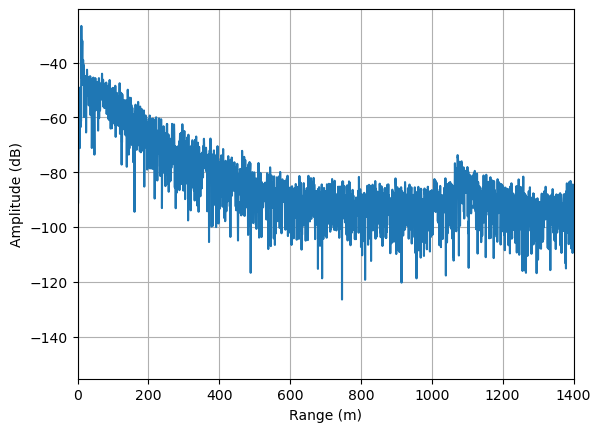

In [56]:
fd.single_chirp.FormProfile().PlotProfile(1400)

### Put these data into an xarray
The methods demonstrated above work well for loading and plotting single chirps, but as discussed above, when we have a large complex pRES dataset with multiple chirps and bursts and attenuator settings, we need a more convenient way of storing and accessing the data. When the data gets very large, we also need to be able to load and process subsets of the data without loading the whole thing into memory. Xarray can help.

xApRES has a collection of tools to load multiple `.dat` files and put them in to a useful structure within an xarray. 

Next we will use one of the tools to load all the data from one dat file:

In [59]:
ds = xa.load.generate_xarray(directory='gs://ldeo-glaciology/GL_apres_2022/A101', 
                             file_numbers_to_process=[30], 
                             remote_load=True)
ds

<xarray.Dataset>
Dimensions:          (time: 94, chirp_time: 40001, chirp_num: 20,
                      attenuator_setting_pair: 2, profile_range: 7134)
Coordinates:
  * time             (time) datetime64[ns] 2022-06-23T01:36:56 ... 2022-06-24...
  * chirp_time       (chirp_time) float64 0.0 2.5e-05 5e-05 ... 1.0 1.0 1.0
  * profile_range    (profile_range) float64 0.0 0.2103 ... 1.5e+03 1.5e+03
  * chirp_num        (chirp_num) int64 0 1 2 3 4 5 6 7 ... 13 14 15 16 17 18 19
    filename         (time) <U83 'ldeo-glaciology/GL_apres_2022/A101/CardA/DI...
    burst_number     (time) int64 0 1 2 3 4 5 6 7 8 ... 86 87 88 89 90 91 92 93
    AFGain           (attenuator_setting_pair) int64 -4 -14
    attenuator       (attenuator_setting_pair) float64 5.0 5.0
    orientation      (time) <U7 'unknown' 'unknown' ... 'unknown' 'unknown'
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    chirp            (time, chirp_time, chirp_num, attenuator_setting_pair) float64 ...
    profile          (time, profile_range, chirp_num, attenuator_setting_pair) complex128 ...
    latitude         (time) float64 68.71 68.71 68.71 ... 68.71 68.71 68.71
    longitude        (time) float64 -49.55 -49.55 -49.55 ... -49.55 -49.55
    battery_voltage  (time) float64 13.89 13.87 13.94 ... 13.85 13.84 13.84
    temperature_1    (time) float64 2.031 0.4609 508.9 ... 1.641 0.2656 510.9
    temperature_2    (time) float64 5.195 3.039 3.234 ... 4.805 2.25 0.6797

The resulting xarray has five dimensions:
- `attenuator_setting_pair`: this is an index referring to the attenuator setting.
- `time`: the time of aquisistion of each burst. 
- `chirp_time`: the time since the beginning of each chirp of each sample within a chirp. As each chirp lasts 1 second, chirp_time varies from 0 to 1 second. There are 40001 samples by default, so the length of `chirp_time` is 40001. 
- `chirp_num`: this is number of chirps in each burst using each attenuator_setting_pair. So if the ApRES unit was configured to use 2 attenuator setting pairs and produce 20 chirps for each in each burst, the total number of chirps in a burst will be 2x20 = 40. 
- `profile_range`: the range to each sample in the profiles computed from each chirp using the fft. 

The two most important data variables are:
- `chirp`: the voltage measured during each chirp after the received signal is mixed with the simultaneously transmitted signal and low-pass filtered. This is an array of real values. 
- `profile`: the profiles resulting from an fft of the chirps. This is an array of complex values.
  



In [60]:
ds.nbytes/1e9

1.632827896

We can now use xarray to slicing, simple processing and plotting of the data, which would be time consuming and error prine using the raw data. For example, in one line we can select one of the two attenuator setting, compute decibels from the profile data, take the mean of the chirps in each burst, and plot the results:

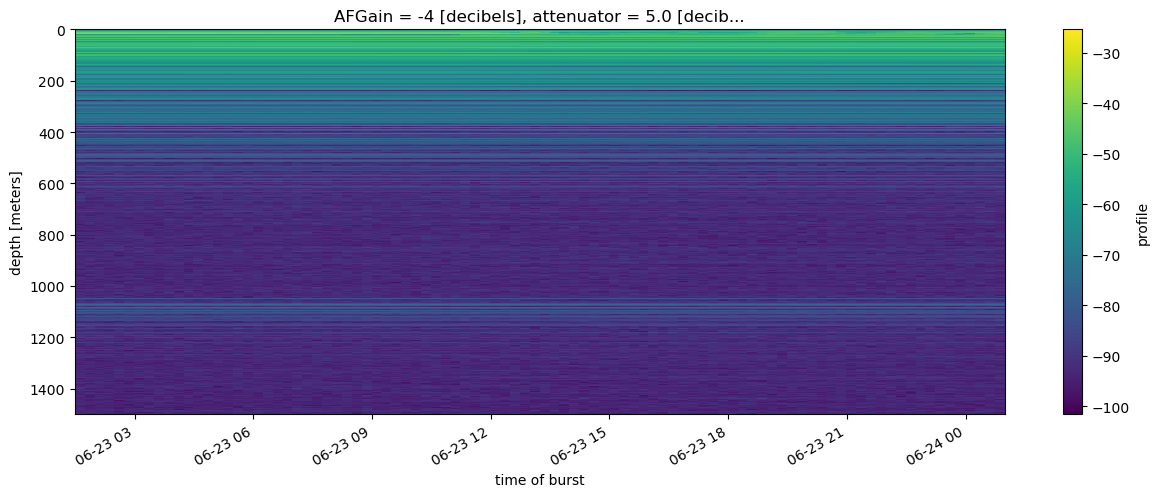

In [81]:
ds.profile.isel(attenuator_setting_pair = 0).dB().mean(dim=['chirp_num']).plot(x='time', yincrease=False, size=(5),aspect=3);


### Write to a zarr directory
Finally, we are on to the stage where we are going to write a zarr directory. The motivation for doing this the speed with which we will be able to access the data: it took 2 minutes to load and process the very small subset of data above. If we want to do calculations using more of the dataset, itwould be impractical to run `xa.load.generate_xarray` each time. 




These are currently notes: I need to flesh this out: 
(note to self: info on what I did is partly in to_individual_zarr_notes.ipynb)

Major issue is that the whole dataset is 200GB. 
I cant fit that into memory and append to zarr didnt work, so my plan was to individually write each dat-worth of data to a zarr, then load lazily, then concat, then write. 

I managed to concat the data and get a lazily loaded xarrray which was the full dataset, but when it came to writing this to one zarr directory it failed. The issue was chunking, specifcally rechunking. The chunks were not uniform in the xarray becuase some dat files were larger than others. arr needs uniform chunk sizes along each dimension (i.e. chunk sizes can be different in diferent dimensions, but they need to be uniform along each dimension). So when it came to writing the one large zarr, I was actually asking it to do a huge rechunking exerciese which can be very inefficient and caused the memory to fill up and the kernel to die. 

The answer was to load each dat file, write to zarr while rechunking to 1 in the time dimension, then load each one lazily, then concat, then rechuning to 20 in the time dimenstion, then write to zarr.